In [ ]:
#import libs
from torchvision.datasets import EuroSAT
import torchvision.transforms as tt
import itertools
import torch
from torchvision import models
from torchvision.models import AlexNet_Weights
import seaborn as sns
import numpy as np
import torch.optim as optim
import ssl
import torch.nn as nn
from sklearn import metrics
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler # Sampler
from sklearn.metrics import confusion_matrix

In [ ]:
!unzip EuroSAT.zip -d /content/data/eurosat

# **Download e Analise do Dataset**

In [ ]:
#transform_testing = tt.Compose([tt.ToTensor()])
# Resizes short size of the PIL image to 256
# Crops a central square patch of the image
# 224 because torchvision's AlexNet needs a 224x224 input!
# Remember this when applying different transformations, otherwise you get an error
# Normalizes tensor with mean and standard deviation

mean, stdev = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # for not pre-trained
_transform = tt.Compose([tt.Resize(256), tt.CenterCrop(224),  tt.ToTensor(), tt.Normalize(mean, stdev)])
import eurosat
dataset = eurosat.EuroSAT(root ='data', download =False, transform = _transform)

data/eurosat
data/eurosat/2750
data/eurosat/2750


In [ ]:
#transform = tt.ToTensor()
#To solve local certificate errors
# import ssl
#ssl._create_default_https_context = ssl._create_unverified_context
#dataset = EuroSAT( download =True , root ="./ data ",transform = transform )

In [ ]:
# analisar/visualizar e analisar dataset, para perceber a distribuicao e etc...

size_data = int(len(dataset))
print(f"Size of the dataset: {size_data}")

TrainingSIZE = int(len(dataset)*0.80) #80% treino
TestingSIZE = int(len(dataset)*0.20) #20% test

training_data , testing_data = torch.utils.data.random_split( dataset , [ TrainingSIZE , TestingSIZE ])

# numero de exemplos de treino:
size_train = len(training_data)
print(f"Number of train data: {size_train}")

# numero de exemplos de teste:
size_test = len(testing_data)
print(f"Number of test data: {size_test}")

Size of the dataset: 27000
Number of train data: 21600
Number of test data: 5400


In [ ]:
# saber dimensoes e n = 3 canais, por ser RGB
image, label = training_data[0]  # Assuming you want to inspect the first image in the dataset.
_channels, _height, _width = image.shape
print(f"Channels*Height*Width: {_channels}*{_height}*{_width}")

Channels*Height*Width: 3*224*224


In [ ]:
# Lets start to obtain training indices
num_train = len(training_data)
print("Number of images in original training set: " + str(num_train)) # 50 000
indices = list(range(num_train))

# Randomly Shuffle
np.random.shuffle(indices)

# Split 80%/20%
split = int(np.floor(num_train * 0.2)) # 4320 -> 20% de 21600

print("Split Number: " + str(split))
training_idx, valid_idx = indices[split:], indices[:split] #
print("Number of training images: " + str(len(training_idx)))
print("Number of validation images: " + str(len(valid_idx)))

Number of images in original training set: 21600
Split Number: 4320
Number of training images: 17280
Number of validation images: 4320


In [ ]:
# To train the network, you must "encode" the data into a PyTorch dataloader
# Since you divided the original training set in 2, now you need to assign the indices to the samples
training_sampler = SubsetRandomSampler(training_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 32 # 16 images per batch

# Training Set
training_loader = torch.utils.data.DataLoader(dataset = training_data, \
                                              batch_size = batch_size, \
                                              sampler = training_sampler)

# Validation Set
valid_loader = torch.utils.data.DataLoader(dataset = training_data, \
                                           batch_size = batch_size, \
                                           sampler = valid_sampler)

# Testing Set
# Here, you do not need the "sampler" input, since you did not change the original testing set
testing_loader = torch.utils.data.DataLoader(dataset = testing_data, \
                                           batch_size = batch_size, \
                                           shuffle = True)


In [ ]:
#vizualizar o batch
#dataiter = iter(training_loader)
#images, labels = next(dataiter) # Get the images and their labels

# nome das classes presentes no dataset
class_names = [ 'AnnualCrop', 'Forest', 'HerbaceousVegetation','Highway',
                'Industrial','Pasture','PermanentCrop','Residential',
                'River','SeaLake']

# Plot the whole batch
#fig = plt.figure(figsize=(25, 4))
# Loop over all the images in the batch(16)
#for idx in np.arange(batch_size):
    # Add a subplot for the image
#    ax = fig.add_subplot(2, int(batch_size/2), idx+1, xticks=[], yticks=[])
    # Subplot with the image

#    image = np.transpose(images[idx].numpy(), (1, 2, 0)) #debug
    # Plot the image
#    ax.imshow(image) #debug

    # esta linha da da nos o numero da classe:labels[idx].item()
    # print out the correct label for each image
#    ax.set_title(class_names[labels[idx].item()])

# **AlexNet From Scratch**

In [ ]:
# alexnetfrom stracth
alexnet = models.alexnet(pretrained=False)


# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We just changed the last layer of AlexNet with a new fully connected layer with 10 outputs

alexnet.classifier[6]=nn.Linear(4096,10)
print("From stracth AlexNet Architecture: "+ str(alexnet))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('\nThe model will run on', device)
alexnet = alexnet.to(device)

# Using the torchsummary, you can check your network in more detail
import torchsummary
print("\n\n")
torchsummary.summary(alexnet, input_size = (3, 224, 224), batch_size = 32)

From stracth AlexNet Architecture: AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

**Treino**

(Validation Set) Epoch: 1 Loss: 0.028063031451569662 Acc: 67.03703703703704
(Validation Set) Epoch: 2 Loss: 0.02367774372989381 Acc: 72.5
(Validation Set) Epoch: 3 Loss: 0.022144524435754175 Acc: 75.81018518518519
(Validation Set) Epoch: 4 Loss: 0.017982754276858436 Acc: 80.55555555555556
(Validation Set) Epoch: 5 Loss: 0.014383886899385188 Acc: 83.95833333333333
(Validation Set) Epoch: 6 Loss: 0.013988530956622627 Acc: 85.23148148148148
(Validation Set) Epoch: 7 Loss: 0.015423278308783967 Acc: 83.14814814814815
(Validation Set) Epoch: 8 Loss: 0.009712008161780734 Acc: 89.42129629629629
(Validation Set) Epoch: 9 Loss: 0.012601719304263868 Acc: 86.80555555555556
(Validation Set) Epoch: 10 Loss: 0.009798897829562149 Acc: 89.30555555555556
Training is completed!


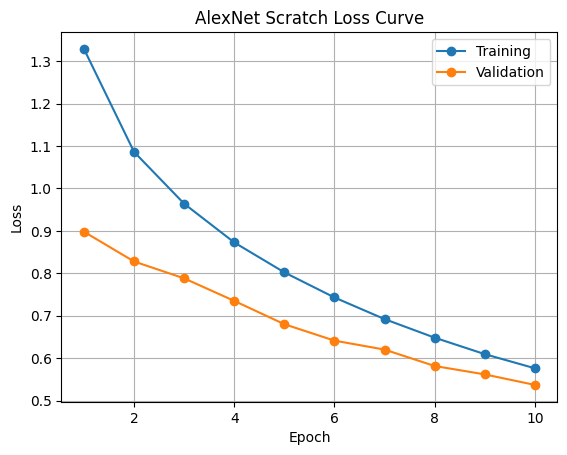

In [ ]:
# To train a CNN, you must choose (or develop) a loss function, an optimizer algorithm, and a set of hyper-parameters (learning rate, number of epochs, etc)
# Hyper-parameters
lr = 0.0001
num_epochs = 10

# Loss Function
criterion = nn.CrossEntropyLoss() # Cross entropy loss function is widely used in classification problems
# Optimizer Algorithm
optimizer = optim.Adam(alexnet.parameters(), lr = lr, weight_decay = 0.0001)

# Training
running_loss = 0.0
training_loss=[]
validation_loss = []
mean_validation_loss = []
mean_training_loss = []

for epoch in range(num_epochs):
  for batch_id, data in enumerate(training_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Pass images through the CNN
    outputs = alexnet(images)

    # Create a loss value
    loss = criterion(outputs, labels)
    training_loss.append(loss.item())

    # Backpropagation
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward()
    optimizer.step()

    # Check some statistics
    running_loss += loss.item()

        # Check some statistics
    running_loss += loss.item()
    training_loss.append(loss.item())
    if batch_id % 1000 == 999: # prints every 1000 batchs
      print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_id + 1, running_loss / 1000))
      running_loss = 0.0

  # For each epoch, analize the model performance
  valid_correct = 0
  valid_total = 0
  valid_total_loss = 0
  with torch.no_grad(): # In this part, you will not train, so you don't need to calculate gradients
    for valid_batch_id, valid_data in enumerate(valid_loader, 0):
      valid_images, valid_labels = valid_data
      valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
      valid_outputs = alexnet(valid_images)
      valid_loss = criterion(valid_outputs, valid_labels)
      valid_total_loss += valid_loss.item()
      validation_loss.append(valid_loss.item())
      _, valid_predicted = torch.max(valid_outputs.data, 1)
      valid_total += valid_labels.size(0)
      valid_correct += (valid_predicted == valid_labels).sum().item()

        #print(valid_labels)
  mean_validation_loss.append(sum(validation_loss)/len(validation_loss))
  mean_training_loss.append(sum(training_loss)/len(training_loss))
  print("(Validation Set) Epoch: " + str(epoch + 1) + " Loss: " + str(valid_total_loss/ len(valid_idx)) + " Acc: " + str(100*valid_correct/valid_total))

print("Training is completed!")
plt.title('AlexNet Scratch Loss Curve')
plt.plot(list(range(1,num_epochs+1)),mean_training_loss,'-o')
plt.plot(list(range(1,num_epochs+1)),mean_validation_loss,'-o')
plt.grid(True)
plt.legend(['Training','Validation'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


**Teste**

Accuracy using 5400 test images: 89.66666666666667 %



<Axes: >

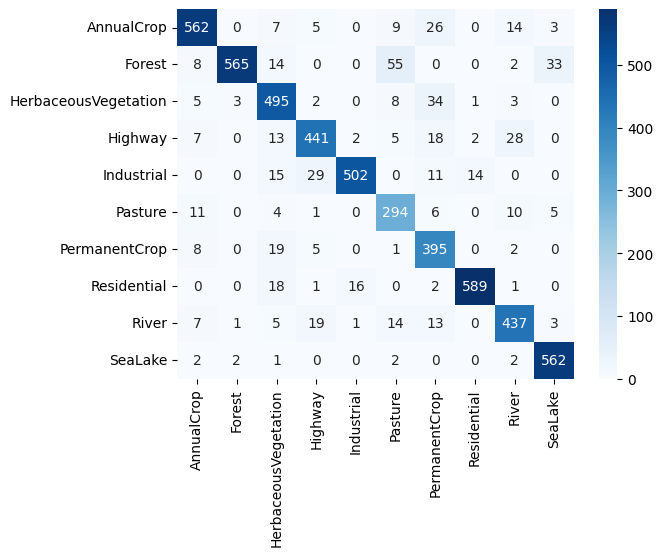

In [ ]:
# Evaluate a CNN is similar to the training process without the backpropagation.
# To evaluate a CNN, we need to follow the evaluation metrics
num_classes = 10
correct = 0
total = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]

alexnet.eval()
predict_array = []
labels_array = []

with torch.no_grad(): # You are not training, so you don't need to calculate gradients
  for batch_id, data in enumerate(testing_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Calculate the CNN's predictions by running images through the network
    outputs = alexnet(images)

    # The class with the highest
    _, predicted = torch.max(outputs.data, 1)

    # Get model's performance
    predict_array.append(predicted.cpu())
    labels_array.append(labels.cpu())

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()

    for i in range(len(images)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

    conf_matrix+=confusion_matrix(predicted.cpu(), labels.cpu(),labels=[x for x in range( num_classes )])


# Show model's performance
print('Accuracy using {} test images: {} %\n'.format(total,100 * correct / total))

# Confusion Matrix
sns.heatmap(conf_matrix, fmt='d', annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [ ]:
from sklearn import metrics
predict_array = np.concatenate(predict_array)
labels_array = np.concatenate(labels_array)
print(f"Evaluation metrics {total} for test images")
print('Accuracy : {} %\n'.format(100 * correct / total))
print("Precision score: {:.2f}%".format((metrics.precision_score(labels_array, predict_array,  average='macro'))*100))
print("Recall score:  {:.2f}%".format((metrics.recall_score(labels_array, predict_array,  average='macro'))*100))
print("F1 score: {:.2f}%".format((metrics.f1_score(labels_array, predict_array,  average='macro'))*100))

Evaluation metrics 5400 for test images
Accuracy : 89.66666666666667 %

Precision score: 89.69%
Recall score:  89.04%
F1 score: 89.15%


# **AlexNet Pre-treinado**

In [ ]:
#transform_testing = tt.Compose([tt.ToTensor()])
# Resizes short size of the PIL image to 256
# Crops a central square patch of the image
# 224 because torchvision's AlexNet needs a 224x224 input!
# Remember this when applying different transformations, otherwise you get an error
# Normalizes tensor with mean and standard deviation

mean, stdev = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
_transform = tt.Compose([tt.Resize(256), tt.CenterCrop(224),  tt.ToTensor(), tt.Normalize(mean, stdev)])
import eurosat
dataset = eurosat.EuroSAT(root ='data', download =False, transform = _transform)

data/eurosat
data/eurosat/2750
data/eurosat/2750


In [ ]:
# analisar/visualizar e analisar dataset, para perceber a distribuicao e etc...

size_data = int(len(dataset))
print(f"Size of the dataset: {size_data}")

TrainingSIZE = int(len(dataset)*0.80) #80% treino
TestingSIZE = int(len(dataset)*0.20) #20% test

training_data , testing_data = torch.utils.data.random_split( dataset , [ TrainingSIZE , TestingSIZE ])

# numero de exemplos de treino:
size_train = len(training_data)
print(f"Number of train data: {size_train}")

# numero de exemplos de teste:
size_test = len(testing_data)
print(f"Number of test data: {size_test}")

Size of the dataset: 27000
Number of train data: 21600
Number of test data: 5400


In [ ]:
# saber dimensoes e n = 3 canais, por ser RGB
image, label = training_data[0]  # Assuming you want to inspect the first image in the dataset.
_channels, _height, _width = image.shape
print(f"Channels*Height*Width: {_channels}*{_height}*{_width}")

Channels*Height*Width: 3*224*224


In [ ]:
# Lets start to obtain training indices
num_train = len(training_data)
print("Number of images in original training set: " + str(num_train)) # 50 000
indices = list(range(num_train))

# Randomly Shuffle
np.random.shuffle(indices)

# Split 80%/20%
split = int(np.floor(num_train * 0.2)) # 4320 -> 20% de 21600

print("Split Number: " + str(split))
training_idx, valid_idx = indices[split:], indices[:split] #
print("Number of training images: " + str(len(training_idx)))
print("Number of validation images: " + str(len(valid_idx)))

Number of images in original training set: 21600
Split Number: 4320
Number of training images: 17280
Number of validation images: 4320


In [ ]:
# To train the network, you must "encode" the data into a PyTorch dataloader
# Since you divided the original training set in 2, now you need to assign the indices to the samples
training_sampler = SubsetRandomSampler(training_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 32 # 16 images per batch

# Training Set
training_loader = torch.utils.data.DataLoader(dataset = training_data, \
                                              batch_size = batch_size, \
                                              sampler = training_sampler)

# Validation Set
valid_loader = torch.utils.data.DataLoader(dataset = training_data, \
                                           batch_size = batch_size, \
                                           sampler = valid_sampler)

# Testing Set
# Here, you do not need the "sampler" input, since you did not change the original testing set
testing_loader = torch.utils.data.DataLoader(dataset = testing_data, \
                                           batch_size = batch_size, \
                                           shuffle = True)


In [ ]:
# Importar AlexNet treinado com pesos proprios
alexnet_orig = models.alexnet(weights = AlexNet_Weights.IMAGENET1K_V1)


# congelar os pesos para que estes nao sejam alterados durante o treino
for param in alexnet_orig.parameters():
    param.requires_grad = False

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We just changed the last layer of AlexNet with a new fully connected layer with 10 outputs
print("Pre-trained AlexNet Architecture: "+ str(alexnet_orig))
alexnet_orig.classifier[6]=nn.Linear(4096,10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('\nThe model will run on', device)
alexnet_orig = alexnet_orig.to(device)

# Using the torchsummary, you can check your network in more detail
import torchsummary
print("\n\n")
torchsummary.summary(alexnet_orig, input_size = (3, 224, 224), batch_size = 32)

Pre-trained AlexNet Architecture: AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=921

**Treino**

(Validation Set) Epoch: 1 Loss: 0.01574711691312216 Acc: 84.53703703703704
(Validation Set) Epoch: 2 Loss: 0.012899576544899632 Acc: 86.22685185185185
(Validation Set) Epoch: 3 Loss: 0.01190491885429731 Acc: 87.4074074074074
(Validation Set) Epoch: 4 Loss: 0.0112169924950986 Acc: 88.24074074074075
(Validation Set) Epoch: 5 Loss: 0.011040282552992857 Acc: 88.35648148148148
(Validation Set) Epoch: 6 Loss: 0.010500267979309514 Acc: 88.49537037037037
(Validation Set) Epoch: 7 Loss: 0.010195354249811283 Acc: 88.63425925925925
(Validation Set) Epoch: 8 Loss: 0.010077808521412037 Acc: 89.12037037037037
(Validation Set) Epoch: 9 Loss: 0.01011592721376844 Acc: 88.58796296296296
(Validation Set) Epoch: 10 Loss: 0.009668405193628537 Acc: 89.00462962962963
Training is completed!


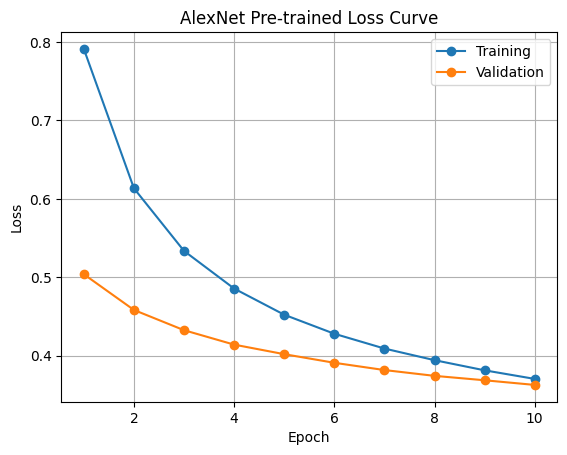

In [ ]:
# To train a CNN, you must choose (or develop) a loss function, an optimizer algorithm, and a set of hyper-parameters (learning rate, number of epochs, etc)
# Hyper-parameters
lr = 0.0001
num_epochs = 10

# Loss Function
criterion = nn.CrossEntropyLoss() # Cross entropy loss function is widely used in classification problems
# Optimizer Algorithm
optimizer = optim.Adam(alexnet_orig.parameters(), lr = lr, weight_decay=0.0001)

# Training
running_loss = 0.0
training_loss=[]
validation_loss = []
mean_validation_loss = []
mean_training_loss = []

for epoch in range(num_epochs):
  for batch_id, data in enumerate(training_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Pass images through the CNN
    outputs = alexnet_orig(images)

    # Create a loss value
    loss = criterion(outputs, labels)
    training_loss.append(loss.item())

    # Backpropagation
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward()
    optimizer.step()

    # Check some statistics
    running_loss += loss.item()

        # Check some statistics
    running_loss += loss.item()
    training_loss.append(loss.item())
    if batch_id % 1000 == 999: # prints every 1000 batchs
      print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_id + 1, running_loss / 1000))
      running_loss = 0.0

  # For each epoch, analize the model performance
  valid_correct = 0
  valid_total = 0
  valid_total_loss = 0
  with torch.no_grad(): # In this part, you will not train, so you don't need to calculate gradients
    for valid_batch_id, valid_data in enumerate(valid_loader, 0):
      valid_images, valid_labels = valid_data
      valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
      valid_outputs = alexnet_orig(valid_images)
      valid_loss = criterion(valid_outputs, valid_labels)
      valid_total_loss += valid_loss.item()
      validation_loss.append(valid_loss.item())
      _, valid_predicted = torch.max(valid_outputs.data, 1)
      valid_total += valid_labels.size(0)
      valid_correct += (valid_predicted == valid_labels).sum().item()

        #print(valid_labels)
  mean_validation_loss.append(sum(validation_loss)/len(validation_loss))
  mean_training_loss.append(sum(training_loss)/len(training_loss))
  print("(Validation Set) Epoch: " + str(epoch + 1) + " Loss: " + str(valid_total_loss/ len(valid_idx)) + " Acc: " + str(100*valid_correct/valid_total))

print("Training is completed!")
plt.title('AlexNet Pre-trained Loss Curve')
plt.plot(list(range(1,num_epochs+1)),mean_training_loss,'-o')
plt.plot(list(range(1,num_epochs+1)),mean_validation_loss,'-o')
plt.grid(True)
plt.legend(['Training','Validation'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


Accuracy using 5400 test images: 90.61111111111111 %



<Axes: >

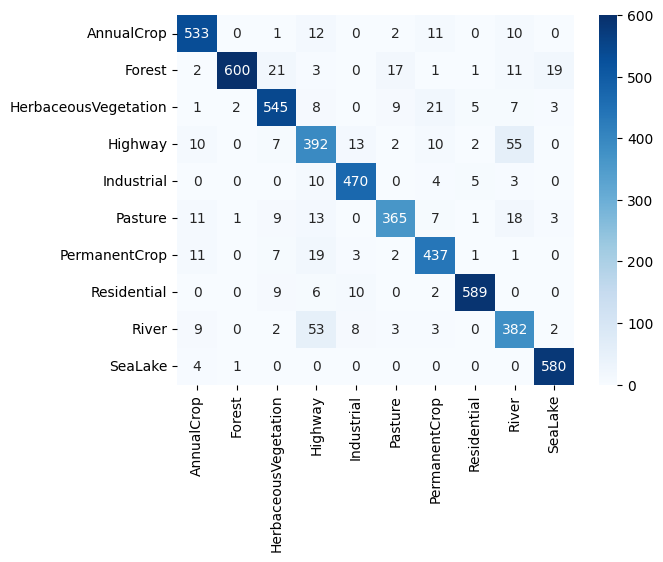

In [ ]:
# Evaluate a CNN is similar to the training process without the backpropagation.
# To evaluate a CNN, we need to follow the evaluation metrics
num_classes = 10
correct = 0
total = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]

alexnet_orig.eval()
predict_array = []
labels_array = []

with torch.no_grad(): # You are not training, so you don't need to calculate gradients
  for batch_id, data in enumerate(testing_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Calculate the CNN's predictions by running images through the network
    outputs = alexnet_orig(images)

    # The class with the highest
    _, predicted = torch.max(outputs.data, 1)

    # Get model's performance
    predict_array.append(predicted.cpu())
    labels_array.append(labels.cpu())

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()

    for i in range(len(images)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

    conf_matrix+=confusion_matrix(predicted.cpu(), labels.cpu(),labels=[x for x in range( num_classes )])


# Show model's performance
print('Accuracy using {} test images: {} %\n'.format(total,100 * correct / total))

# Confusion Matrix
sns.heatmap(conf_matrix, fmt='d', annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [ ]:
from sklearn import metrics
predict_array = np.concatenate(predict_array)
labels_array = np.concatenate(labels_array)
print(f"Evaluation metrics {total} for test images")
print('Accuracy : {} %\n'.format(100 * correct / total))
print("Precision score: {:.2f}%".format((metrics.precision_score(labels_array, predict_array,  average='macro'))*100))
print("Recall score:  {:.2f}%".format((metrics.recall_score(labels_array, predict_array,  average='macro'))*100))
print("F1 score: {:.2f}%".format((metrics.f1_score(labels_array, predict_array,  average='macro'))*100))

Evaluation metrics 5400 for test images
Accuracy : 90.61111111111111 %

Precision score: 90.22%
Recall score:  90.18%
F1 score: 90.14%
